In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from functools import partial

Hyper parameters

In [25]:
reg_param = 0.0001
n_input = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_output = n_input

batch_size = 128
epochs = 10

In [2]:
def load_mnist_csv(path = "/data/MNIST/", one_hot = False, shape = None):
    import pandas as pd
    df_train = pd.read_csv(path + "mnist_train.csv", header=None)
    df_test = pd.read_csv(path + "mnist_test.csv", header=None)
    
    X_train = df_train.iloc[:, 1:].values/255
    X_test = df_test.iloc[:, 1:].values/255
    y_train = df_train.iloc[:, 0].values
    y_test = df_test.iloc[:, 0].values
    
    if shape == "3D":
        X_train = X_train.reshape(-1, 28, 28, 1)
        X_test = X_test.reshape(-1, 28, 28, 1)
    
    if one_hot:
        eye = np.eye(10)
        y_train, y_test = eye[y_train], eye[y_test]
        
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_mnist_csv(one_hot=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000, 10), (10000, 10))

In [3]:
def data_generator(X, y, batch_size = 32, epochs = 1):
    from collections import namedtuple
    from math import ceil
    Batch = namedtuple("batch", ["epoch", "global_step", "progress", "X_batch", "y_batch"])
    global_step = 0
    for epoch in range(epochs):
        m = X_train.shape[0]
        indices = np.arange(m)
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
        num_batches = ceil(m/batch_size)
        for j in range(num_batches):
            start = j * batch_size
            end = start + batch_size
            X_batch = X[start:end]
            y_batch = y[start:end]
            progress = (j + 1) * 100 / num_batches
            yield Batch(epoch, global_step, progress, X_batch, y_batch)
            global_step = global_step + 1

In [39]:
tf.reset_default_graph()

he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(reg_param)
my_dense_layer = partial(tf.layers.dense
                         , activation = tf.nn.relu
                         , kernel_initializer = he_init
                         , kernel_regularizer = l2_regularizer)

X = tf.placeholder(dtype=tf.float32, shape=(None, n_input))

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)

output = my_dense_layer(hidden3, n_output, activation = tf.nn.sigmoid)

mse = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=output) .square(output - X))

reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

cost = mse + tf.reduce_mean(reg_loss)

opt = tf.train.AdamOptimizer(0.001).minimize(cost)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [31]:
with tf.Session() as sess:
    sess.run(init)
    for batch in data_generator(X_train, y_train, batch_size, epochs):
        _, mse_, output_  = sess.run([opt, mse, output], feed_dict={X: batch.X_batch})
        print("Epoch: %d, progress: %3d%%, mse: %.4f" % (batch.epoch, batch.progress, mse_), end="\r")
        if batch.progress == 100:
            print("")
    saver.save(sess, "/tmp/tf/encoder")

Epoch: 0, progress: 100%, mse: 0.0207
Epoch: 1, progress: 100%, mse: 0.0131
Epoch: 2, progress: 100%, mse: 0.0117
Epoch: 3, progress: 100%, mse: 0.0108
Epoch: 4, progress: 100%, mse: 0.0101
Epoch: 5, progress: 100%, mse: 0.0092
Epoch: 6, progress: 100%, mse: 0.0091
Epoch: 7, progress: 100%, mse: 0.0087
Epoch: 8, progress: 100%, mse: 0.0082
Epoch: 9, progress: 100%, mse: 0.0084


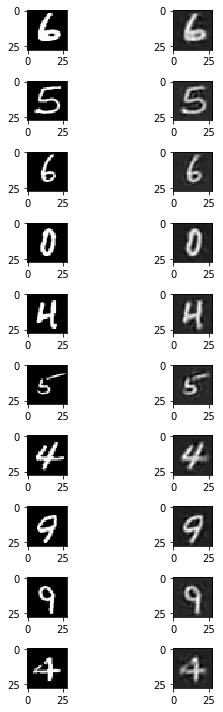

In [32]:
fig, axes = plt.subplots(10, 2, figsize = (5, 10))

for i in range(len(axes)):
    ax0, ax1 = axes[i]
    ax0.imshow(batch.X_batch[i].reshape(28, 28), cmap="gray")
    ax1.imshow(output_[i].reshape(28, 28), cmap="gray")
    

plt.tight_layout()

INFO:tensorflow:Restoring parameters from /tmp/tf/encoder


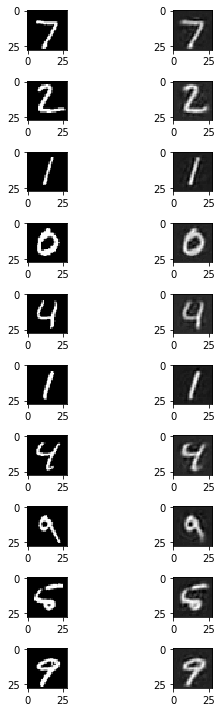

In [33]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/tf/encoder")
    output_  = sess.run(output, feed_dict={X: X_test})

fig, axes = plt.subplots(10, 2, figsize = (5, 10))

for i in range(len(axes)):
    ax0, ax1 = axes[i]
    ax0.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax1.imshow(output_[i].reshape(28, 28), cmap="gray")

plt.tight_layout()

INFO:tensorflow:Restoring parameters from /tmp/tf/encoder


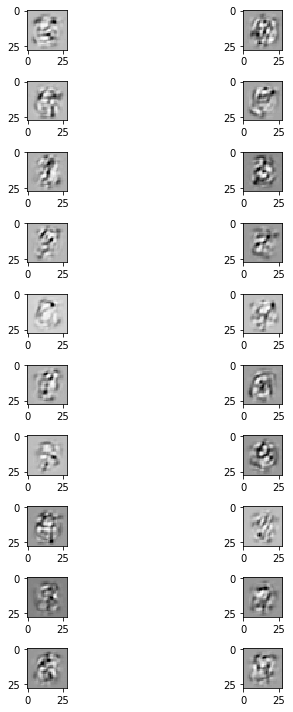

In [35]:
random_inputs = np.random.normal(size=(20, n_hidden2))

with tf.Session() as sess:
    saver.restore(sess, "/tmp/tf/encoder")
    output_  = sess.run(output, feed_dict={hidden2: random_inputs})

fig, axes = plt.subplots(10, 2, figsize = (8, 10))

for i, ax in enumerate(fig.axes):
    ax.imshow(output_[i].reshape(28, 28), cmap="Greys")

plt.tight_layout()